<a href="https://colab.research.google.com/github/An210/ML/blob/main/LSTM_Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install cryptocompare
!pip install seaborn
import seaborn as sns
import requests
import pandas as pd
from datetime import datetime
import cryptocompare
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def get_historical_price_data():
    # Get the current timestamp
    end_time = datetime.now()

    # Calculate the start time (30 days ago)
    start_time = end_time - timedelta(days=120)

    # Convert timestamps to Unix timestamps
    end_timestamp = int(end_time.timestamp())
    start_timestamp = int(start_time.timestamp())

    # Get historical price data
    price_data = cryptocompare.get_historical_price_day(
        'ETH', 'USD', limit=120, toTs=end_timestamp, exchange='CCCAGG'
    )

    # Create a Pandas DataFrame
    df = pd.DataFrame(price_data)

    # Convert 'time' column to datetime objects
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Rename columns to match your desired format
    df = df.rename(
        columns={
            'time': 'Timestamp',
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'volumefrom': 'VolumeFrom',
            'volumeto': 'VolumeTo',
            'close': 'Close',
        }
    )

    return df

# Get historical price data
historical_data = get_historical_price_data()
historical_data = historical_data.drop(['conversionType', 'conversionSymbol'], axis=1)

# Print the DataFrame
print(historical_data.sort_values(by='Timestamp', ascending=False))

     Timestamp     High      Low     Open  VolumeFrom      VolumeTo    Close
120 2024-11-15  3093.01  3035.87  3059.11   195189.73  5.992818e+08  3079.19
119 2024-11-14  3242.46  3029.87  3191.32  1094612.33  3.442350e+09  3059.11
118 2024-11-13  3339.13  3121.10  3247.18  1694646.90  5.472868e+09  3191.32
117 2024-11-12  3446.83  3210.71  3375.79  1572933.12  5.174595e+09  3247.18
116 2024-11-11  3391.44  3108.06  3186.06  1371655.28  4.474445e+09  3375.79
..         ...      ...      ...      ...         ...           ...      ...
4   2024-07-22  3563.26  3424.39  3536.46   293172.34  1.021404e+09  3441.05
3   2024-07-21  3547.99  3413.60  3518.85   237146.07  8.294070e+08  3536.46
2   2024-07-20  3541.04  3482.21  3506.00   155617.03  5.455781e+08  3518.85
1   2024-07-19  3542.18  3376.46  3425.94   362043.38  1.249533e+09  3506.00
0   2024-07-18  3489.81  3367.76  3387.66   294308.06  1.008327e+09  3425.94

[121 rows x 7 columns]


In [114]:
X = historical_data.copy()
y = X.pop("Close")
X['Timestamp'] = pd.to_datetime(X['Timestamp']).astype('int64') // 10**9

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Verify integer types and correct them if needed
X = X.apply(lambda x: pd.to_numeric(x, downcast='integer'))

# Check for discrete features
discrete_features = X.dtypes == 'int'

# Define function for MI scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Calculate MI scores
mi_scores = make_mi_scores(X, y, discrete_features)
print("\nSelected MI Scores:\n", mi_scores[::1])





Selected MI Scores:
 Low           1.646551
High          1.537311
Open          1.043453
Timestamp     0.955450
VolumeFrom    0.145709
VolumeTo      0.037242
Name: MI Scores, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


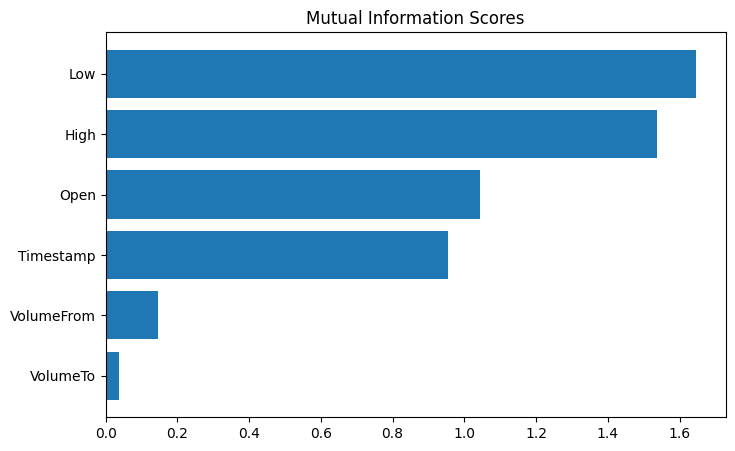

In [115]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

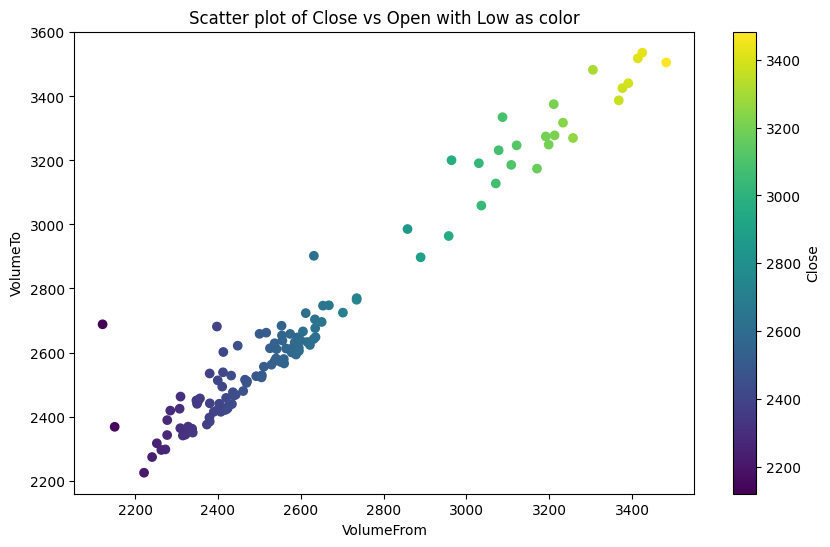

In [129]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = plt.scatter(historical_data["Low"], historical_data["Open"], c=historical_data["Low"], cmap="viridis")
plt.colorbar(scatter, label="Close")
plt.xlabel("VolumeFrom")
plt.ylabel("VolumeTo")
plt.title("Scatter plot of Close vs Open with Low as color")
plt.show()

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length + 1])
    return np.array(sequences)

seq_length = 10  # You can adjust this based on your data
sequences = create_sequences(scaled_data, seq_length)

# Split into features (X) and target (y)
X = sequences[:, :-1]
y = sequences[:, -1, -1]  # We are predicting the 'Close' price
print(X)
print(y)
# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


[[[0.94132262 0.91589692 0.88658018 0.09599648 0.12346715 0.91575834]
  [0.98315971 0.92229007 0.91575834 0.13972373 0.17082368 0.97678247]
  [0.98224899 1.         0.97678247 0.00646302 0.03261478 0.98657713]
  ...
  [0.82331278 0.70956696 0.84655548 0.31220638 0.31684026 0.72408799]
  [0.77861571 0.77069142 0.72408799 0.13347833 0.15004287 0.8006235 ]
  [0.81222439 0.78637302 0.8006235  0.07793666 0.09637815 0.78116377]]

 [[0.98315971 0.92229007 0.91575834 0.13972373 0.17082368 0.97678247]
  [0.98224899 1.         0.97678247 0.00646302 0.03261478 0.98657713]
  [0.98780118 0.94958224 0.98657713 0.05909495 0.08833951 1.        ]
  ...
  [0.77861571 0.77069142 0.72408799 0.13347833 0.15004287 0.8006235 ]
  [0.81222439 0.78637302 0.8006235  0.07793666 0.09637815 0.78116377]
  [0.77708187 0.79145815 0.78116377 0.01561854 0.03390043 0.79701053]]

 [[0.98224899 1.         0.97678247 0.00646302 0.03261478 0.98657713]
  [0.98780118 0.94958224 0.98657713 0.05909495 0.08833951 1.        ]
  [1

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout  # Import Bidirectional and Dropout
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf #Import Tensorflow

model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(seq_length, X.shape[2])))  # Bidirectional LSTM
model.add(Dropout(0.3))  # Increased dropout rate
model.add(Bidirectional(LSTM(50)))  # Bidirectional LSTM
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# Compile with adjusted learning rate and potential regularization
optimizer = keras.optimizers.Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')


model.fit(X_train, y_train, batch_size=1, epochs=20)
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

# Make predictions
predictions = model.predict(X_val)

# Inverse transform the predictions to get the actual close prices
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], X.shape[2] - 1)), predictions), axis=1))[:, -1]
actual_close_prices = historical_data['Close'].iloc[-len(y_val):].values
timestamps = historical_data['Timestamp'].iloc[-len(y_val):].values  # Assuming 'Timestamp' is the column name for timestamps

# Print the predictions along with timestamps
for timestamp, actual, predicted in zip(timestamps, actual_close_prices, predictions):
    print(f'Timestamp: {timestamp}, Actual Close Price: {actual}, Predicted Close Price: {predicted}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0170
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0150
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0197
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0109
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0157
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0163
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0100
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0093
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0180
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0100
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0084
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0110
Epoch 13/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0125
Epoch 14/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0088
Epoch 15/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0076
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Ethereum price for 2024-11-16 00:00:00: 2938.9243392944336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Ethereum price for 2024-11-17 00:00:00: 3022.504327670336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Ethereum price for 2024-11-18 00:00:00: 3084.137031815052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted Ethereum price for 2024-11-19 00:00:00: 3126.1211518371106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Ethereum price for 2024-11-20 00:00:00: 3148.8026344394684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Ethereum price for 2024-11-21 00:00:00: 3152.911142525673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Ethereum price for 2024-11-22 00:00:00: 3143.500672786236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Ethereum price for 2024-11-23 00:00:00: 3123.791407234669
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Ethereum price for 2024-11-24 00:00:00: 3105.407358404398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predic

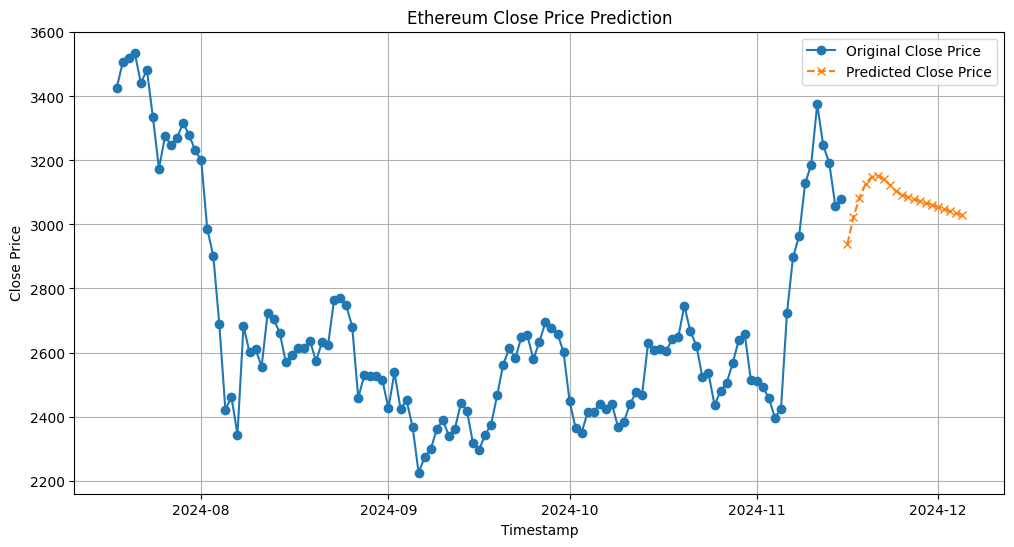

In [126]:
# ... (your existing code for data loading, preprocessing, model training with cross-validation) ...

# Number of days to predict ahead
num_days_ahead = 20

# Get the last 'seq_length' data points from historical_data
current_sequence = scaled_data[-seq_length:]
predictions = []
timestamps = []
# Loop to predict for the next 'num_days_ahead' days
for i in range(num_days_ahead):
    # Reshape the current sequence to match the model's input shape
    current_sequence = current_sequence.reshape((1, seq_length, scaled_data.shape[1]))

    # Make prediction for the next day
    prediction = model.predict(current_sequence)

    # Inverse transform prediction to get actual price
    prediction = scaler.inverse_transform(np.concatenate((np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction), axis=1))[:, -1]

    # Reshape the prediction to match the dimensions of current_sequence
    prediction_reshaped = np.repeat(prediction[:, np.newaxis], scaled_data.shape[1], axis=1)
    prediction_reshaped = prediction_reshaped.reshape(1, 1, scaled_data.shape[1])

    #Create a temporary DataFrame for scaling
    temp_df = pd.DataFrame(prediction_reshaped.reshape(1, -1), columns=['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close'])

    #Scale using the temporary DataFrame
    prediction_scaled = scaler.transform(temp_df).reshape(1, 1, scaled_data.shape[1])

    # Get the timestamp for the prediction
    timestamp = historical_data['Timestamp'].iloc[-1] + pd.Timedelta(days=i + 1)  # Add i+1 days to the last timestamp

    # Print prediction with timestamp
    print(f"Predicted Ethereum price for {timestamp}: {prediction[0]}")
    predictions.append(prediction[0])
    timestamps.append(timestamp)
    # Update the current sequence for the next prediction
    current_sequence = np.append(current_sequence[:, 1:, :], prediction_scaled, axis=1)  # Append the prediction to the sequence and remove the first element

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(historical_data['Timestamp']), historical_data['Close'], label='Original Close Price', marker='o')
plt.plot(timestamps, predictions, label='Predicted Close Price', marker='x', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Ethereum Close Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Backtesting RMSE: 159.04241476445287
Backtesting R-squared: 0.6065865889350374
Backtesting MAPE: 0.04042215710192213


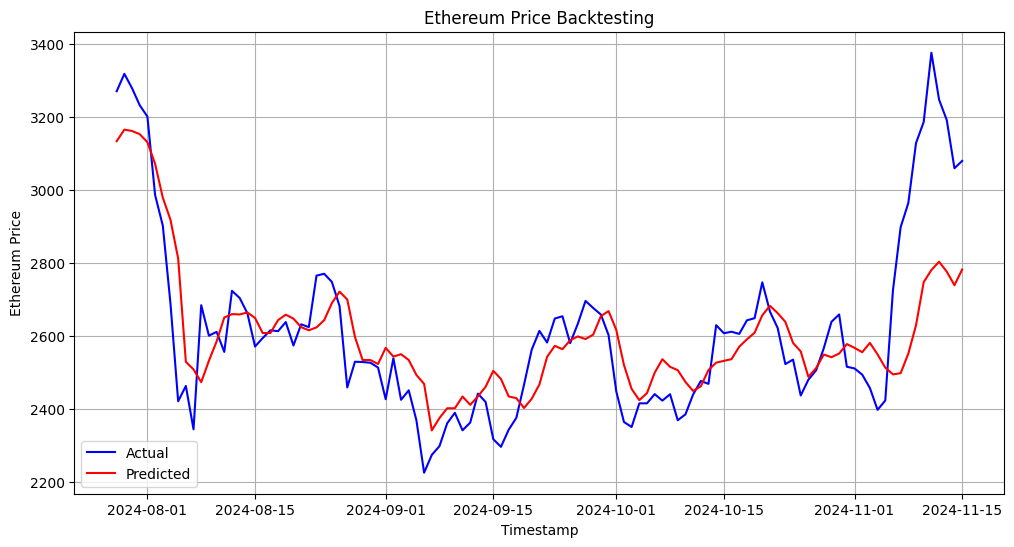

In [127]:
backtest_start_date = '2024-01-01'  # Adjust this to your desired start date
backtest_end_date = '2024-11-15'  # Adjust this to your desired end date

# Filter historical data for the backtesting period
backtest_data = historical_data[(historical_data['Timestamp'] >= backtest_start_date) & (historical_data['Timestamp'] <= backtest_end_date)]

# Prepare backtesting data
scaled_backtest_data = scaler.transform(backtest_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])
backtest_sequences = create_sequences(scaled_backtest_data, seq_length)
X_backtest = backtest_sequences[:, :-1]
y_backtest = backtest_sequences[:, -1, -1]  # We are predicting the 'Close' price

# Make predictions on the backtesting data
backtest_predictions = model.predict(X_backtest)

# Inverse transform the predictions to get the actual close prices
backtest_predictions = scaler.inverse_transform(np.concatenate((np.zeros((backtest_predictions.shape[0], X_backtest.shape[2] - 1)), backtest_predictions), axis=1))[:, -1]

# Evaluate backtesting performance
rmse = np.sqrt(mean_squared_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions))
r2 = r2_score(backtest_data['Close'].iloc[seq_length:], backtest_predictions)
mape = mean_absolute_percentage_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions)

print(f'Backtesting RMSE: {rmse}')
print(f'Backtesting R-squared: {r2}')
print(f'Backtesting MAPE: {mape}')

# Plotting the backtesting results
plt.figure(figsize=(12, 6))
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Actual', color='blue')
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_predictions, label='Predicted', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Ethereum Price')
plt.title('Ethereum Price Backtesting')
plt.legend()
plt.grid(True)
plt.show()

Backtest Profit/Loss for each trade:
[-98.34000000000015, 43.5, 25.51000000000022, 60.61000000000013, 72.33999999999969, 20.190000000000055, -143.30999999999995, -4.650000000000091, -16.980000000000018, -36.75, -59.789999999999964, 25.5300000000002, 302.21000000000004, -172.90999999999985, -66.46000000000004, -164.00999999999976, -58.070000000000164, -189.73000000000002, 128.61000000000013, 55.85999999999967, 132.21000000000004, -20.079999999999927]

Backtest Cumulative Profit/Loss:
-164.50999999999976


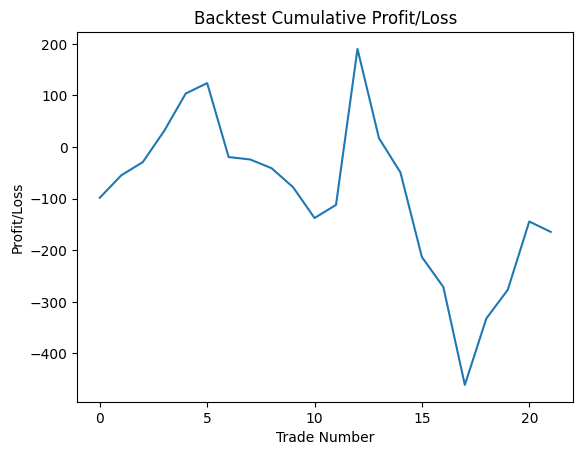

In [147]:
# Calculate Profit/Loss for Backtest
profit_loss_backtest = []
cumulative_profit_loss_backtest = 0

# Ensure that the loop uses the correct length to avoid index errors
num_trades = min(len(backtest_predictions), len(actual_close_prices))

# Assuming a simple buy-and-hold strategy for the backtest:
# Buy if predicted price is higher than previous day's close, sell otherwise
for i in range(1, num_trades):
    if backtest_predictions[i] > actual_close_prices[i - 1]:  # Buy signal
        profit_loss_backtest.append(actual_close_prices[i] - actual_close_prices[i - 1])
    else:  # Sell signal
        profit_loss_backtest.append(actual_close_prices[i - 1] - actual_close_prices[i])

    cumulative_profit_loss_backtest += profit_loss_backtest[-1]

# Print the backtest results
print("Backtest Profit/Loss for each trade:")
print(profit_loss_backtest)
print("\nBacktest Cumulative Profit/Loss:")
print(cumulative_profit_loss_backtest)

# You can also plot the cumulative profit/loss over time for the backtest
plt.plot(np.cumsum(profit_loss_backtest))
plt.title("Backtest Cumulative Profit/Loss")
plt.xlabel("Trade Number")
plt.ylabel("Profit/Loss")
plt.show()